#### Code to train models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src

/home/theo/kaggle/siim_covid/src


## Imports

In [3]:
import os
import cv2
import ast
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from tqdm.notebook import tqdm

In [4]:
from params import *

In [5]:
from data.preparation import prepare_dataframe, handle_duplicates, add_additional_boxes
from data.dataset import CovidDetDataset, CovidClsDataset
from data.transforms import get_transfos_det, get_transfos_cls

from model_zoo.models import get_model
from model_zoo.encoders import get_encoder

from utils.plot import plot_sample
from utils.boxes import treat_boxes
from utils.logger import prepare_log_folder, save_config, create_logger, update_overall_logs

from training.main import k_fold

## Data

### Load

In [6]:
df = prepare_dataframe().copy()

In [7]:
clusts = np.load("../output/clusts.npy", allow_pickle=True)
found = np.load("../output/found.npy")
transpositions = np.load("../output/transpositions.npy", allow_pickle=True)

df = handle_duplicates(df, clusts, transpositions, plot=False)

In [8]:
df = add_additional_boxes(df)

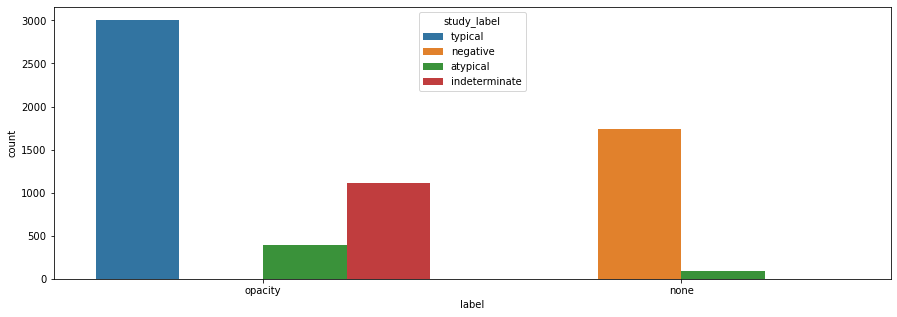

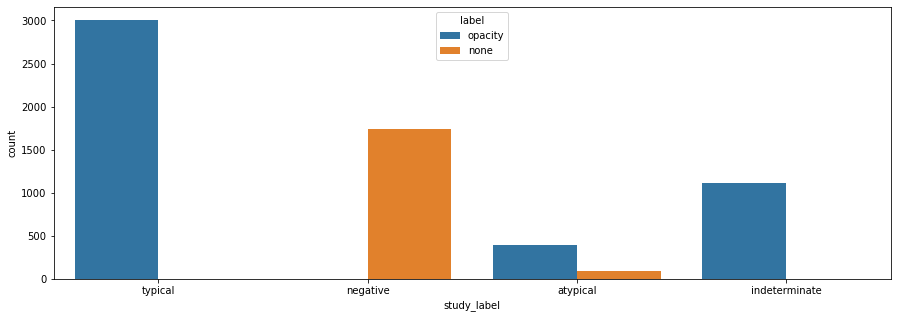

In [9]:
plt.figure(figsize=(15, 5))
sns.countplot(x="label", hue="study_label", data=df)
plt.show()

plt.figure(figsize=(15, 5))
sns.countplot(x="study_label", hue="label", data=df)
plt.show()

### PL

In [10]:
df_test = pd.read_csv('../input/df_test_512.csv')

In [11]:
df_test['shape'] = df_test['shape'].apply(lambda x: np.array(x[1:-1].split(', ')).astype(int))
df_test['shape_crop'] = df_test['shape_crop'].apply(lambda x: np.array(x[1:-1].split(', ')).astype(int))
df_test['crop_starts'] = df_test['crop_starts'].apply(lambda x: np.array(x[1:-1].split(', ')).astype(int))

In [12]:
pl_study = pd.read_csv('../output/sub_0931_study.csv')
pl_study["study_id"] = pl_study["id"].apply(lambda x: x.split('_')[0])
pl_study.drop(['id', 'PredictionString'], axis=1, inplace=True)

In [13]:
pl_img = pd.read_csv('../output/sub_0931_img.csv')
pl_img["image_id"] = pl_img["id"].apply(lambda x: x.split('_')[0])
pl_img.drop(['id', 'PredictionString'], axis=1, inplace=True)

In [14]:
df_test = df_test.merge(pl_study, how="left", on="study_id")
df_test = df_test.merge(pl_img, how="left", on="image_id")

In [15]:
df['is_pl'] = 0
df_test['is_pl'] = 1

df['root'] = DATA_PATH + f"train_{SIZE}/"
df_test['root'] = DATA_PATH + f"test_{SIZE}/"

In [16]:
df_test['kfold'] = -1
df_test['img_target'] = 1 - df_test['none']

### Dataset

In [17]:
df_ = df[df['crop_starts'].apply(lambda x: np.max(x) > 100)].reset_index()

In [18]:
transforms = get_transfos_det(augment=True, bbox_format="yolo")

In [19]:
dataset = CovidDetDataset(df_, DATA_PATH + f"train_{SIZE}/", bbox_format="yolo", transforms=transforms)

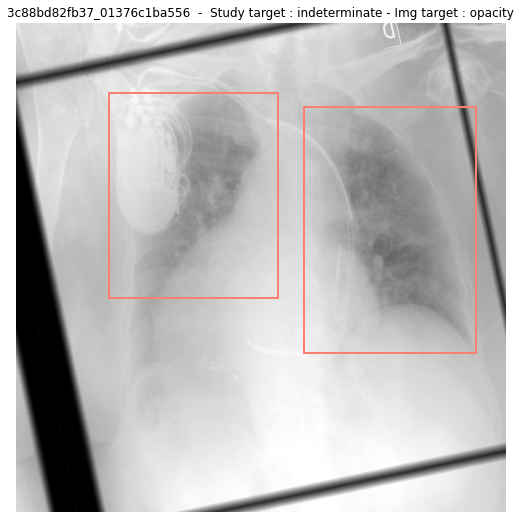

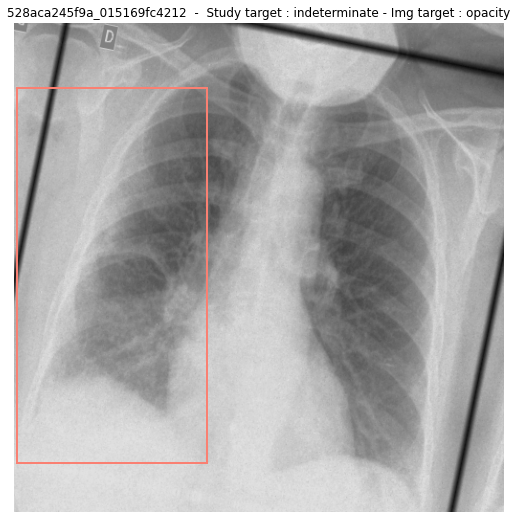

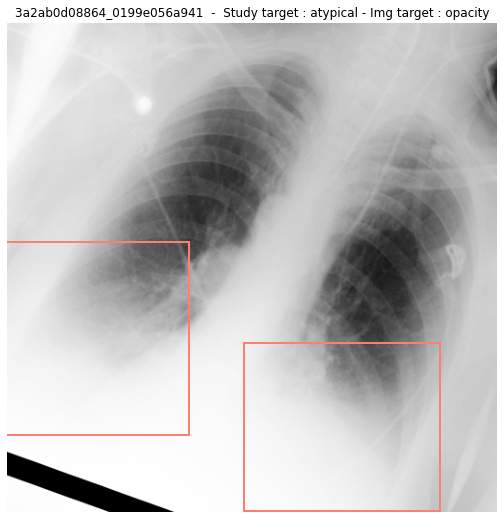

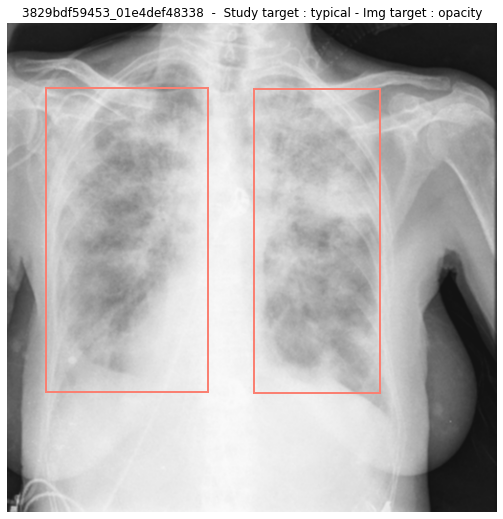

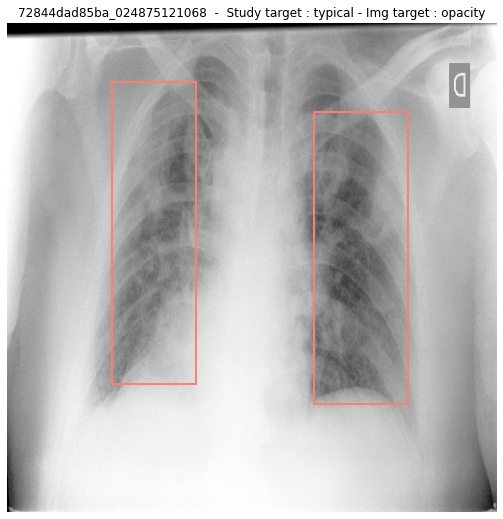

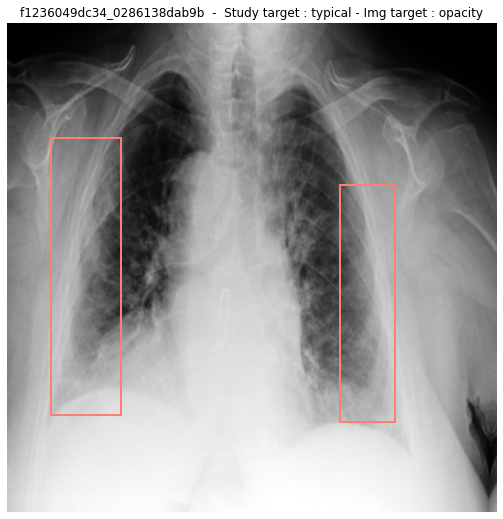

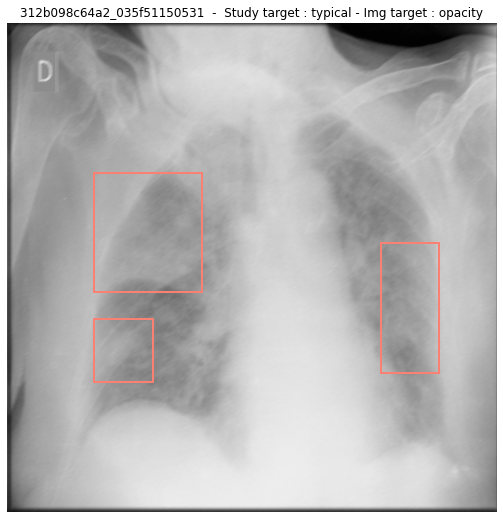

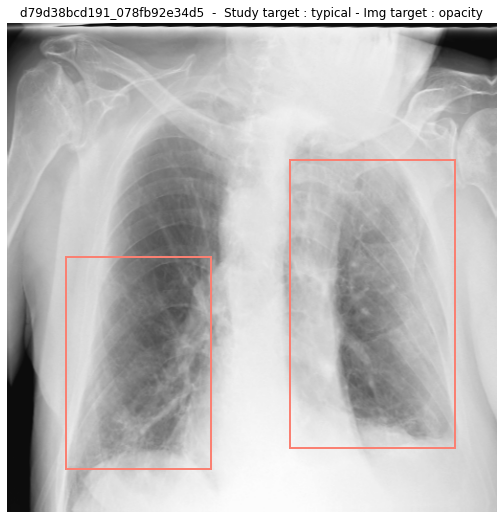

In [20]:
# for i in np.random.choice(len(dataset), 10):
for i in range(10):
    img, mask, y, y_img, boxes = dataset[i]
    
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy().transpose(1, 2, 0)
        mask = mask.cpu().numpy()[:, :, None]

    if len(boxes):
        plt.figure(figsize=(9, 9))
        plot_sample(img, boxes, bbox_format="yolo")
        plt.title(
            f'{df_["save_name"][i][:-4]}  -  Study target : {CLASSES[int(y)]} - '
            f'Img target : {CLASSES_IMG[int(y_img)]}'
        )
        plt.show()

## Model

In [21]:
# model = get_encoder('tf_efficientnet_b4_ns')

In [22]:
model = get_model('tf_efficientnetv2_s_in21ft1k', num_classes=4)

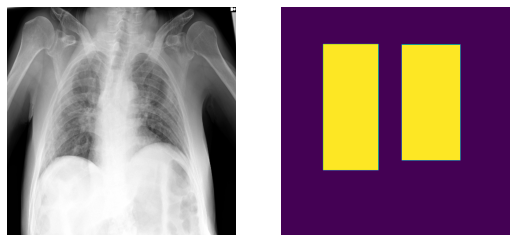

In [23]:
transforms = get_transfos_cls(augment=False)
dataset = CovidClsDataset(df, DATA_PATH + f"train_{SIZE}/", transforms=transforms)

x, m, y, y_img, _ = dataset[0]

plt.figure(figsize=(9, 9))
plt.subplot(1, 2, 1)
plt.imshow(x.cpu().numpy().transpose(1, 2, 0))
plt.axis(False)
plt.subplot(1, 2, 2)
plt.imshow(m.cpu().numpy()[:, :, None])
plt.axis(False)

x = x.unsqueeze(0).float()
m = m.unsqueeze(0).float()
y = y.unsqueeze(0)
y_img = y_img.unsqueeze(0)

In [24]:
model.encoder.nb_fts

[48, 64, 160, 256]

In [25]:
pred = model(x)

In [26]:
for p in pred:
    try:
        print(p.size())
    except:
        for p_ in p:
            print(' ', p_.size())

torch.Size([1, 4])
torch.Size([1, 1])
  torch.Size([1, 1, 32, 32])
  torch.Size([1, 1, 16, 16])


In [27]:
from training.losses import *

In [28]:
loss = SmoothCrossEntropyLoss()

In [29]:
loss(pred[0], y), loss(pred[0], torch.tensor([[0, 1, 0, 0]]).long()), nn.CrossEntropyLoss(reduction="none")(pred[0], y.long())

(tensor([1.1358], grad_fn=<SumBackward1>),
 tensor([1.1358], grad_fn=<SumBackward1>),
 tensor([1.1358], grad_fn=<NllLossBackward>))

### Training

In [30]:
BATCH_SIZES = {
    "resnext50_32x4d": 16,
    'tf_efficientnetv2_s_in21ft1k': 8, # 16
    'tf_efficientnetv2_m_in21ft1k': 12, #6
    'tf_efficientnetv2_l_in21ft1k': 6,
    'tf_efficientnet_b2_ns': 12,
    'tf_efficientnet_b3_ns': 16,
    'tf_efficientnet_b4_ns': 12,
    'tf_efficientnet_b5_ns': 8,
}

In [31]:
class Config:
    """
    Parameters used for training
    """
    # General
    seed = 42
    verbose = 1

    size = SIZE
    bbox_format = "yolo"
    root_dir = DATA_PATH + f"train_{SIZE}/"
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    save_weights = True

    # k-fold
    k = 5
    folds_col = "kfold"
    selected_folds = [0, 1, 2, 3, 4]

    # Model
    selected_model = 'tf_efficientnetv2_m_in21ft1k'
    use_unet = False
    num_classes = len(CLASSES)

    # Training
    loss_config = {  
        "w_bce": 0.75,
        "w_seg_loss": 0.95 if "v2_s" in selected_model else 0.75,
        "seg_loss_multiplier": 4 if "v2_s" in selected_model else 2,
        "w_study": 2,
        "w_img": 1,
    }
    use_fp16 = False if "v2_s" in selected_model else True
    samples_per_patient = 1
    optimizer = ["Adam", "RAdam_lookahead", "RAdam"]
    batch_size = BATCH_SIZES[selected_model]
    epochs = [8] #, 5, 5]

    lr = [1e-3, 1e-4, 1e-5]
    warmup_prop = [0.05, 0.25, 0.5]
    val_bs = batch_size * 2

    first_epoch_eval = 0
     
    mix = "cutmix"
    mix_proba = 0.5
    mix_alpha = 0.4

    name = "model"

In [32]:
DEBUG = False
log_folder = None

In [ ]:
if not DEBUG:
    log_folder = prepare_log_folder(LOG_PATH)
    print(f'Logging results to {log_folder}')
    save_config(Config, log_folder + 'config')
    df.to_csv(log_folder + 'data.csv', index=False)
    create_logger(directory=log_folder, name="logs.txt")

pred_oof_study, pred_oof_img = k_fold(
    Config,
    df,
    df_extra=df_test,
    log_folder=log_folder
)

Logging results to ../logs/2021-08-03/3/

-------------   Fold 1 / 5  -------------

    -> 6327 training images
    -> 1269 validation images
    -> 55231203 trainable parameters

 - Training 1 / 1 : 	epochs: 8	lr: 1.0e-03	warmup_prop: 0.05	optimizer: Adam
Using 504 out of 527 batches by limiting to 1 samples per study.

Epoch 01/08 	 lr=9.2e-04	 t=204s 	loss=1.151	val_loss=0.930	study_map=0.337	img_auc=0.885
Epoch 02/08 	 lr=7.9e-04	 t=203s 	loss=0.928	val_loss=0.890	study_map=0.369	img_auc=0.887
Epoch 03/08 	 lr=6.6e-04	 t=204s 	loss=0.897	val_loss=0.902	study_map=0.359	img_auc=0.889
Epoch 04/08 	 lr=5.3e-04	 t=203s 	loss=0.870	val_loss=0.871	study_map=0.377	img_auc=0.894
Epoch 05/08 	 lr=4.0e-04	 t=203s 	loss=0.834	val_loss=0.853	study_map=0.370	img_auc=0.898
Epoch 06/08 	 lr=2.6e-04	 t=203s 	loss=0.806	val_loss=0.873	study_map=0.377	img_auc=0.901
Epoch 07/08 	 lr=1.3e-04	 t=204s 	loss=0.767	val_loss=0.854	study_map=0.378	img_auc=0.906
Epoch 08/08 	 lr=7.8e-07	 t=203s 	loss=0.701	v